#### Kathryn Monopoli
#### Artificial Intelligence (CS 534) - Assignment 4 


# Naive Bayes Classifier

a) You should implement from scratch a Naïve Bayes classifier (using the spam filter example discussed in class). 
* Also implement Laplacian smoothing to handle words not in the dictionary.

b) Using the implemented algorithm, train and test the model for each dataset.
* Use 80% of each class data to train your classifier and the remaining 20% to test it. 
* Which dataset provides better classification i.e. email body or email subject?

c) Compare your classifier with the scikit-learn implementation (sklearn.naive_bayes.MultinomialNB).
* Repeat the analysis from (b)

## a) Implement from scratch a Naïve Bayes classifier
* Also implement Laplacian smoothing to handle words not in the dictionary.


In [1]:
# Methods for training the model
import numpy as np
import random
import string

def train_spam_filter(df,k):
    '''Trains the spam filter from a set of Spam and Ham words.
        Implements Laplacian smoothing to consider cases where the word is not present
        in the original messages.
    
    parameters:
        df: dataframe of words where each column represents a word and each row represents an email 
        k: float tunable parameter for Laplacian smoothing 
    returns:
        p_ham_dict: dictionary containing words and their probability that those words are in a ham email
        p_spam_dict: dictionary containing words and their probability that those words are in a spam email
        missing_key: String representing the key in the dictionaries for any missing words - allows implementation of Laplacian smoothing for missing words
    '''
    prob_ham_dict = dict()
    prob_spam_dict = dict()

    # total number of words that are in ham emails
    num_words_ham = df[df['CLASS'] == 1][df.columns[:-1]].values.sum()
    # total number of words that are in spam emails
    num_words_spam = df[df['CLASS'] == 0][df.columns[:-1]].values.sum()
    # size of vocabulary
    sz_voc = len(df.columns)-1 # subtract 1 because 'CLASS' column is not part of the vocabulary
    
    print("Number of ham words:",num_words_ham)
    print("Number of spam words:",num_words_spam)
    print("Vocabulary size:",sz_voc,"\n")
    
    for w in df.columns[:-1]: # Exclude last column from iteration ('CLASS')
        # count occurences of w in spam
        num_w_spam = df[df['CLASS'] == 0][w].values.sum() 
        # compute the conditional probability - that the word w is in spam email
        prob_w_spam = (float(num_w_spam) + k)/(float(num_words_spam) + k*sz_voc) 
        # count occurences of w in ham
        num_w_ham = df[df['CLASS'] == 1][w].values.sum() 
        # compute the conditional probability - that the word w is in ham email
        prob_w_ham = (float(num_w_ham) + k)/(float(num_words_ham) + k*sz_voc) 
        # add probability of w being ham/spam to dictionaries
        prob_ham_dict[w] = prob_w_ham
        prob_spam_dict[w] = prob_w_spam

    # add additional term to the dictionary to account for missing values 
    missing_key = 'missing_word'
    # make sure this word doesn't already exist in the dictionary
    try: # only completes this try block of code if the missing world already exists in the dictionary (because for some reason it showed up in a training example email message)
        prob_ham_dict[missing_key] # only have to check one of the dictionaries because they both contain the same words
        # if word already exists then append a random set of characters to it to make it unique
        missing_key+='_'+get_random_string(20)
        print("Key existed so new missing_key is:",missing_key)
    except:
        pass

    prob_missing_word_ham = (k)/(float(num_words_ham) + k*sz_voc) 
    prob_missing_word_spam = (k)/(float(num_words_spam) + k*sz_voc) 
    prob_ham_dict[missing_key] = prob_missing_word_ham
    prob_spam_dict[missing_key] = prob_missing_word_spam
    
    return prob_ham_dict,prob_spam_dict,missing_key 


def get_random_string(length):
    '''Generates a random string of lenght length'''
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str



def compute_priors(df):
    '''Computes the prior probabilities than an email is ham or spam based off of the number of ham and spam emails in the training set
    parameters:
        df: dataframe of words where each column represents a word and each row represents an email 
    returns:
        prior_ham float - the prior probability that an email is ham
        prior_spam float - the prior probability that an email is spam
    '''
    prior_ham = (len(df[df['CLASS'] == 1]))/(len(df[df['CLASS'] == 1])+len(df[df['CLASS'] == 0]))
    prior_spam = (len(df[df['CLASS'] == 0]))/(len(df[df['CLASS'] == 1])+len(df[df['CLASS'] == 0]))  
    return prior_ham,prior_spam



# Methods For assessing the model
def compute_prob(prob_dict,prior,words,missing_key):
    '''Computes the probability (of an email being spam or ham depending on the prob_dict passed in)
        Considers each word occurence and independent event and then computes the probability by
        multiplying the probabilities of each word in words based on its corresponding probability
        value in prob_dict by each other and by the prior probability
    parameters:
        prob_dict dictionary containing words and their associated probabilities (as floats) of a particular event
        prior: prior probability
        words: list of Strings representing a single email
        missing_key: String representing the key in the dictionaries for any missing words
    returns:
        probs: float between 0 and 1 representing probability of an event (email being ham or spam)
    '''
    probs = [prior]
    for w in words:
        try:
            probs.append(prob_dict[w])
        except: # case where word is missing - pre-computed to implement Laplacian smoothing
            probs.append(prob_dict[missing_key])
    probs = np.prod(probs)
    return probs

def predict_spam_email(words,p_ham_dict,p_spam_dict,prior_ham,prior_spam,missing_key):
    '''Returns a prediction of a single email being ham or spam based on the model
    parameters:
        words: list of Strings representing words in a single email
        p_ham_dict: dictionary containing words and their probability that those words are in a ham email
        p_spam_dict: dictionary containing words and their probability that those words are in a spam email
        prior_ham: prior probability that the email is ham
        prior_spam: prior probability that the email is spam
        missing_key: String representing the key in the dictionaries for any missing words
    returns:
        int 1 if ham 0 if spam
    '''
    import numpy as np
    # remove "CLASS" if it is still there
    words = [x for x in words if x!= 'CLASS']
    prob_w_ham = compute_prob(p_ham_dict,prior_ham,words,missing_key)
    prob_w_spam = compute_prob(p_spam_dict,prior_spam,words,missing_key)
    # is spam
    if prob_w_spam > prob_w_ham:
        return 0
    # is ham
    else:
        return 1

def predict(df,missing_key):
    '''Takes a dataframe of words and their occurences in emails and returns a list of 1's and 0's
        reprsenting ham or spam prediction respectively for each email 
    parameters:
        df: dataframe of words where each column represents a word and each row represents an email 
        missing_key: String representing the key in the dictionaries for any missing words
    returns:
        pred_ls: list of ints - 1's and 0's representing ham and spam predictions respectively
                 The order of this list corresponds to the order of the emails in the dataframe
    '''
    # Iterate through each email in the dataset
    pred_ls = []
    for index, row in df.iterrows():
        words = list(row[row >0].index)
        # perform predictions for each email and store in a list
        pred_ls.append(predict_spam_email(words,p_ham_dict,p_spam_dict,prior_ham,prior_spam,missing_key))
    return pred_ls


def plot_confusion_matrix_spam_classifier(actual,predicted,title):
    '''Plots a confusion matrix for the spam email classifier
    parameters:
        predicted: list of ints 0's and 1's representing positive and negative predictions for the classes
        actual: list of ints 0's and 1's representing positive and negative classes
        title: String representing the title of the plot
    '''
    from sklearn.metrics import confusion_matrix
    from matplotlib import pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib
    matplotlib.rcParams['font.sans-serif'] = "Arial" 
    matplotlib.rcParams['font.family'] = "sans-serif" 
    matplotlib.rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    cm = confusion_matrix(actual,predicted)
    tn, fp, fn, tp = cm.ravel()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Spam","Ham"])
    disp.plot(cmap='GnBu',ax=ax)
    ax.set_title(title)
    plt.savefig(title.replace(" ","_")+"_confusion_matrix.png",dpi=300,bbox_inches="tight",transparent=True)
    
def f_measure(actual,predicted):
    '''compute f-measure from array of actual and predicted values'''
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    return (2*pre*rec)/(pre+rec)



## b) Using the implemented algorithm, train and test the model for each dataset.

### Load in email dataset

In [2]:
import pandas as pd
# Email Bodies
body_df = pd.read_csv('emails/dbworld_bodies_stemmed.csv')
# Email Subjects
subj_df = pd.read_csv('emails/dbworld_subjects_stemmed.csv')

# drop id columns
body_df.drop(columns = ['id'],inplace=True)
subj_df.drop(columns = ['id'],inplace=True)

display(body_df)
display(subj_df)


,000euro,05102011,10th,11th,12noon,12th,13th,14th,15th,16th,...,znie,zurich,zürich,ètop,özsu,û37,û42,û46,û56,CLASS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,10th,13th,1st,2nd,31st,3rd,5th,6th,abstract,academ,...,vacanc,valencia,vehicular,video,web,wireless,workflow,workshop,zurich,CLASS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split data into training and testing datasets

In [3]:
# Here we are splitting by the amount in each class, so we first need to determine the number of spam and ham emails in the training dataset
# We assume the body and subject datasets represent the same messages so we can do these initial computations based on the body_df only

test_p_sz = 0.2

ham_ct = len(body_df[body_df['CLASS'] == 1])
spam_ct = len(body_df[body_df['CLASS'] == 0])

print(ham_ct, "Ham emails")
print(spam_ct, "Spam emails")

train_ham_sz = int(round((1-test_p_sz)*ham_ct,0))
train_spam_sz = int(round((1-test_p_sz)*spam_ct,0))

print("Training set will have",train_ham_sz,"ham emails and",train_spam_sz,"spam emails")
print("Test set will have",ham_ct-train_ham_sz,"ham emails and",spam_ct-train_spam_sz,"spam emails")



29 Ham emails
35 Spam emails
Training set will have 23 ham emails and 28 spam emails
Test set will have 6 ham emails and 7 spam emails


In [4]:
## Subjects
# subjects ham
from sklearn.model_selection import train_test_split

# subjects ham
subj_df_train_ham, subj_df_test_ham, subj_class_train_ham, subj_class_test_ham = train_test_split(
    subj_df[subj_df['CLASS'] == 1].drop(columns=['CLASS']),subj_df[subj_df['CLASS'] == 1]['CLASS'], test_size=test_p_sz)

# subjects spam
subj_df_train_spam, subj_df_test_spam, subj_class_train_spam, subj_class_test_spam = train_test_split(
    subj_df[subj_df['CLASS'] == 0].drop(columns=['CLASS']),subj_df[subj_df['CLASS'] == 0]['CLASS'], test_size=test_p_sz)

# compile subjects ham and spam
subj_df_train = pd.concat([subj_df_train_spam,subj_df_train_ham])
subj_class_train = pd.concat([subj_class_train_spam,subj_class_train_ham])
subj_df_test = pd.concat([subj_df_test_spam,subj_df_test_ham])
subj_class_test = pd.concat([subj_class_test_spam,subj_class_test_ham])

# plot 
# subj_class_train.value_counts().plot(kind='bar', title = 'Subject Training Set')





In [5]:
## Bodies
# bodies ham
body_df_train_ham, body_df_test_ham, body_class_train_ham, body_class_test_ham = train_test_split(
    body_df[body_df['CLASS'] == 1].drop(columns=['CLASS']),body_df[body_df['CLASS'] == 1]['CLASS'], test_size=test_p_sz)

# bodies spam
body_df_train_spam, body_df_test_spam, body_class_train_spam, body_class_test_spam = train_test_split(
    body_df[body_df['CLASS'] == 0].drop(columns=['CLASS']),body_df[body_df['CLASS'] == 0]['CLASS'], test_size=test_p_sz)

# compile bodies ham and spam
body_df_train = pd.concat([body_df_train_spam,body_df_train_ham])
body_class_train = pd.concat([body_class_train_spam,body_class_train_ham])
body_df_test = pd.concat([body_df_test_spam,body_df_test_ham])
body_class_test = pd.concat([body_class_test_spam,body_class_test_ham])

# plot 
# body_class_train.value_counts().plot(kind='bar', title = 'Body Training Set')





In [6]:

print("Training set size body text:",len(body_df_train))
print("Test set size body text:",len(body_df_test))
print("Training set size subj text:",len(subj_df_train))
print("Test set size subj text:",len(subj_df_test))

Training set size body text: 51
Test set size body text: 13
Training set size subj text: 51
Test set size subj text: 13


## Train the Model on Email Subjects


In [7]:
subj_df_train['CLASS'] = subj_class_train

print("Training on Email Subjects:\n")
prior_ham,prior_spam = compute_priors(subj_df_train) 
print("Prior probability is ham:",prior_ham)
print("Prior probability is spam:",prior_spam)

# alpha for Laplacian smoothing
alpha = 1.0

p_ham_dict,p_spam_dict,missing_key = train_spam_filter(subj_df_train,alpha) 



Training on Email Subjects:

Prior probability is ham: 0.45098039215686275
Prior probability is spam: 0.5490196078431373
Number of ham words: 156
Number of spam words: 167
Vocabulary size: 229 



## Assess the model on Email Subjects


F-measure: 0.923076923076923


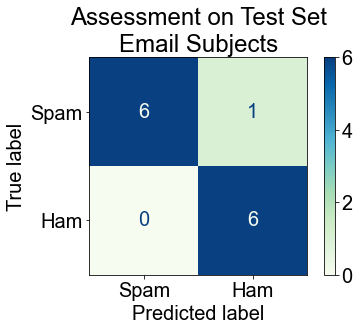

In [8]:
# perform assessment - drop the class column for prediction
predictions = predict(subj_df_test,missing_key) 

# Compute F-measure
print("F-measure:",f_measure(subj_class_test,predictions)) 

# Plot a Confusion Matrix to visualize model performance
plot_confusion_matrix_spam_classifier(subj_class_test,predictions,'Assessment on Test Set\nEmail Subjects') 




## Train the Model on Email Bodies


In [9]:
body_df_train['CLASS'] = body_class_train


print("Training on Email Bodies:\n")
prior_ham,prior_spam = compute_priors(body_df_train)
print("Prior probability is ham:",prior_ham)
print("Prior probability is spam:",prior_spam)
# use same alpha as before for Laplacian smoothing
p_ham_dict,p_spam_dict,missing_key = train_spam_filter(body_df_train,alpha)



Training on Email Bodies:

Prior probability is ham: 0.45098039215686275
Prior probability is spam: 0.5490196078431373
Number of ham words: 5381
Number of spam words: 4232
Vocabulary size: 3721 



## Assess the model on Email Bodies


F-measure: 0.7058823529411764


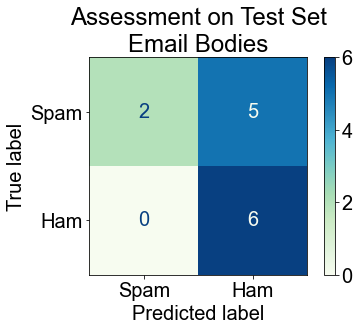

In [10]:
# perform assessment - drop the class column for prediction
predictions = predict(body_df_test,missing_key) 

# Compute F-measure
print("F-measure:",f_measure(body_class_test,predictions)) 

# Plot a Confusion Matrix to visualize model performance
plot_confusion_matrix_spam_classifier(body_class_test,predictions,'Assessment on Test Set\nEmail Bodies') 





# c) Compare your classifier with the scikit-learn implementation

## On Email Subjects


F-measure: 0.923076923076923


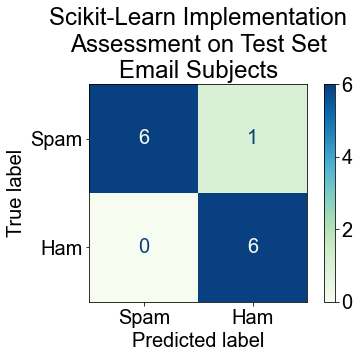

In [11]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
try: # To account for case where the class column was added to the training data
    clf.fit(subj_df_train.drop(columns=['CLASS']), subj_class_train)
except:
    clf.fit(subj_df_train, subj_class_train)
    
# perform assessment 
predictions_nb = clf.predict(subj_df_test)



# Compute F-measure
print("F-measure:",f_measure(subj_class_test,predictions_nb))

# Plot a Confusion Matrix to visualize model performance
plot_confusion_matrix_spam_classifier(subj_class_test,predictions_nb,'Scikit-Learn Implementation\nAssessment on Test Set\nEmail Subjects')




## On Email Bodies


F-measure: 0.8571428571428571


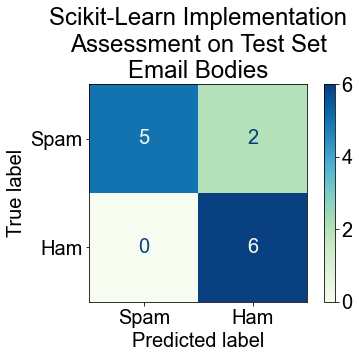

In [12]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
try: # To account for case where the class column was added to the training data
    clf.fit(body_df_train.drop(columns=['CLASS']), body_class_train)
except:
    clf.fit(body_df_train, body_class_train)
    
# perform assessment 
predictions_nb = clf.predict(body_df_test)



# Compute F-measure
print("F-measure:",f_measure(body_class_test,predictions_nb))

# Plot a Confusion Matrix to visualize model performance
plot_confusion_matrix_spam_classifier(body_class_test,predictions_nb,'Scikit-Learn Implementation\nAssessment on Test Set\nEmail Bodies')



